In [1]:
# This file is the Jupyter notebook for the Machine Learning 1 Lab 1
# Author: Tom Pengilly
# Group Members: Tom Pengilly, Quynh Chao, Michael Weatherford, Anish Patel
# Date: 9/3/2020


Dataset Source: https://www.kaggle.com/rmjacobsen/property-listings-for-5-south-american-countries?select=co_properties.csv

# Business Purpose
The South American Real Estate Listings is a super data set that aggregated property listings from five separate data sets published by Kaggle. This information contains a wide variety of real estate properties and may be used by corporate developers, individual investors, retirees and expatriates doing their due diligence in considering potential acquisitions, investment or living arrangements. 

The original data sets contain property listings from five countries: Argentina, Columbia, Ecuador, Peru, and Uruguay collected by Prosperati Data, the data division of the Latin American search company Prosperati. For pu
rposes of comparability and analysis, we aggregated the five databases resulting in a super data set that has over 2 million rows with 26 attributes and took multiple steps to wrangle the combined data set so as to have a clean final data set for exploratory data analysis.

We will be using regression analysis to predict pricing for real estate properties that are listed for sale in select South American countries. We will split the data into training and test sets, and measure the performance of our model based on the RMSE.  The analysis can be considered successful if we can create a model that sufficiently minimizes the RMSE, allowing our users to use the predicted fair market value in considering whether to purchase a property.

# Data Understanding: 
The following section includes the code used to for data wrangling, missing/outlier handling, visualization, attribute relations, and interesting findings.

## Data Meaning
The data set contains listings of properties from February 2019 through March 2020.  Some listings may still be live at the date of this report.  The properties listed may not be unique since this data set contains transactions.  Therefore, it is possible for there to be multiple sequential listings for the same property, if that property was bought and sold, or unlisted and relisted during the same time periods covered by the data set.  We did not remove multiple listings for the same property because these may reflect multiple price changes.

id: property id number. Not unique for all observations.
ad_type: type of listing.
    Propiedad (Property)
    Desarrollo/Proyecto (Development/Project)
start_date: listing date
end_date: listing cancellation date
created_on: date of registration of FIRST version of listing for a given property
lat: latitude
lon: longitude
l1: administrative level 1: Country
l2 - Administrative Level 2: Usually the province of the property.
l3 - Administrative Level 3: Usually the city of the property.
l4 - Administrative Level 4: Usually the neighbourhood of the property.
l5 – Administrative Level 5: Subregion of neighborhood of property
l6: Any??????
rooms: total number of rooms
bedrooms: number of bedrooms
bathrooms: number of bathrooms
surface_total: total area in  m².
surface_covered - Area covered in m².
price - Price published in the listing.
currency - Currency of published price.
price_period - Payment periods:
    Diario (Daily)
    Semanal (Weekly)
    Mensual (Monthly)
title - Title of the listing (These are in Spanish).
description - Description of the listing (listing body) (In Spanish).
property_type: type of property
    Casa (House)
    Deparamento (Apartment)
    Lote (Lot)
    PH (Horizontal Property: Condominium or other property where owners seperately own portions of the property and collectively own portions of the property)
    Oficina (Office)
    Otro (Other)
    Local comercial (Shop)
    Cochera (Garage)
    Deposito (Warehouse)
    Parqueadero (Parking Lot)
    Finca (Farm)
    Casa de campo (Cottage)
operation_type: Type of listing
    Venta (Sale)
    Alquiler (Rent)
    Alquiler temporal (Temporary rental)

## Data Wrangling: 
The data wrangling code used to concatenate, clean, and convert our data is shown below.  The first section deals with creating our final dataset for use in our analysis.

There were multiple steps taken to build our South American Real Estate Listing data set used for analysis.

1. Aggregation of five Prosperati datasets from Kaggle
2. Reformat attributes into ordinal, continuous, and categorical in order to explore/change them more easily
3. Clean the data for inconsistent values such as: remove listings that have not yet expired (end date 9999-12-31), that have no price or currency,  removing factor levels that are not of interest, and converting prices to USD using exchange rate histories. Exchange rate data source: https://www.investing.com/currencies/. The exchange rate chosen corresponded to the end-date of the listing.
4. Missing/invalid data were omitted. Given the large number of records we have from the aggregated data set of 2M, the omission of rows with invalid or missing data values, excluding numeric variables, would not negatively impact our EDA. 
5. Thousands of duplicate observations were removed.
6. The dataset was filtered to exclude properties for rent, since the price is listed in different units (dollars/month).
7. The final cleaned data set had 25 attributes and 694,993 rows of real estate listings for sale (operation_type == Venta) in five South American countries (l1 = Argentina, Brazil, Uruguay, Ecuador, and Peru). 


In [202]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import set_option
set_option('display.max_columns',400)
from pandas_profiling import ProfileReport
import copy as cp
import os
import glob
import matplotlib as mplt
import re
import datetime
from scipy.stats import ks_2samp, ttest_ind
import seaborn as sns
from IPython.display import Image
# from pandas.tools.plotting import scatter_matrix
# from pandas.tools.plotting import parallel_coordinates

In [ ]:
# Concatenate all data files and create the combined dataset
os.chdir('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\DatasetAndPreprocessing')
path = os.getcwd()
print(path)

#Read and Concat all data files
all_files = glob.glob(path + "/*.csv")
property_data = []

# Create the combined dataset

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    property_data.append(df)

combineddf = pd.concat(property_data, axis=0, ignore_index=True, sort = False)

In [ ]:
# Reformat attributes in order to explore/change them more easily
# Split variables into ordinal, continuous and categorical
ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price']
categorical_vars = ['ad_type', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'currency', 'price_period', 'property_type', 'operation_type']
string_vars = ['id', 'title', 'description']
time_vars = ['start_date', 'end_date', 'created_on']

# Create a dataframe with  missing values as -1 or 0 (this is done to allow the datatypes to be changed)
# dates of 9999-12-31 are replaced w/ 1970-01-01 since this value is used to determine exchange rates and throws an error
combineddf[ordinal_vars] = combineddf[ordinal_vars].replace(to_replace = np.nan, value = -1)
combineddf[time_vars] = combineddf[time_vars].replace(to_replace = "9999-12-31", value = 0)

# Change data types
combineddf[ordinal_vars] = combineddf[ordinal_vars].astype(np.int64)
combineddf[continuous_vars] = combineddf[continuous_vars].astype(np.float64)
combineddf[categorical_vars] = combineddf[categorical_vars].astype('category')
combineddf[string_vars] = combineddf[string_vars].astype(str)
combineddf[time_vars] = pd.to_datetime(combineddf[time_vars].stack(), format = "%Y-%m-%d").unstack()

## 1. Verify data quality.
The data has 25 variables (17 categorical and 8 continuous) with 694,993 observations.  There were thousands of duplicate observations and millions of missing data points.  Further investigation of the data revealed that most of the missing values were coming from the l4, l5, l6, and price period variables.  L4, L5, L6 are the administrative levels that indicate Subregion, Neighborhood, and smaller subdivisions, while price period indicates the frequency at which payments are made.  Since these variables were missing in the majority of observations and could not be reasonably imputed, they were removed from the data set.  It is expected that their removal will not significantly impact the performance of our price prediction model. 

In addition to these rooms, bedrooms, bathrooms, lat, lon, surface_covered, and surface_total had some missing values, but these were not removed since they can be imputed later.

In [ ]:
# Remove listings that have not yet expired (end date 1970-01-01)
indices = []
for row in range(len(combineddf)):
    if combineddf.end_date[row].strftime('%Y-%m-%d') == '1970-01-01':
        indices.append(row)
reduceddf = combineddf.drop(combineddf.index[indices], inplace = False)
reduceddf = reduceddf.reset_index(drop=True)

# Remove listings that have no price or currency
indices = []
for row in range(len(reduceddf)):
    if reduceddf.price[row] == 0:
        indices.append(row)
    if pd.isnull(reduceddf.price[row]):
        indices.append(row)
    if pd.isnull(reduceddf.currency[row]):
        indices.append(row)
reduceddf2 = reduceddf.drop(combineddf.index[indices], inplace = False)
reduceddf2 = reduceddf2.reset_index(drop=True)

# Combine factor levels that are equivalent
reduceddf2 = reduceddf2.replace(to_replace = 'Estados Unidos de América', value = 'Estado Unidos')

#### Price Conversion
The following code is used to read in historical exchange rate data between all currencies and USD. This data is used to convert all prices to the same scale. The transaction end_date was used as the date of exchange, if the date isn't listed in the price histories, the date is decremented until a recent exchange rate was found.

In [ ]:
# Convert prices to USD using exchange rate histories. 
# The exchange rate for the given currency pair is looked up for the end_date
arsusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_ARS Historical Data.csv', header = 0)
copusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_COP Historical Data.csv', header = 0)
penusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_PEN Historical Data.csv', header = 0)
uyuusd = pd.read_csv('C:\\Users\\Tpeng\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Price Data\\USD_UYU Historical Data.csv', header = 0)


# Convert price in reduceddf to USD 
for obs in range(len(reduceddf2)):
    if reduceddf2.currency[obs] != 'USD':
        currency = reduceddf2.currency[obs]
        date = reduceddf2.end_date[obs]
        
        if date.strftime('%Y-%m-%d') != '1970-01-01':
            if reduceddf2.currency[obs] == 'ARS':
                while date.strftime('%Y-%m-%d') not in list(arsusd.Date):
                    date = date - datetime.timedelta(days = 1)
                exchange_rate = arsusd.Price[arsusd.Date == date.strftime('%Y-%m-%d')]
                reduceddf2.at[obs, 'price'] = reduceddf2.price[obs] / float(exchange_rate)
                reduceddf2.at[obs, 'currency'] = 'USD'
            if reduceddf2.currency[obs] == 'UYU':
                while date.strftime('%Y-%m-%d') not in list(uyuusd.Date):
                    date -= datetime.timedelta(days = 1)
                exchange_rate = uyuusd.Price[uyuusd.Date == date.strftime('%Y-%m-%d')]
                reduceddf2.at[obs, 'price'] = reduceddf2.price[obs] / float(exchange_rate)
                reduceddf2.at[obs, 'currency'] = 'USD'
            if reduceddf2.currency[obs] == 'PEN':
                while date.strftime('%Y-%m-%d') not in list(penusd.Date):
                    date -= datetime.timedelta(days = 1)
                exchange_rate = penusd.Price[penusd.Date == date.strftime('%Y-%m-%d')]
                reduceddf2.at[obs, 'price'] = reduceddf2.price[obs] / float(exchange_rate)
                reduceddf2.at[obs, 'currency'] = 'USD'
            if reduceddf2.currency[obs] == 'COP':
                while date.strftime('%Y-%m-%d') not in list(copusd.Date):
                    date -= datetime.timedelta(days = 1)
                exchange_rate = copusd.Price[copusd.Date == date.strftime('%Y-%m-%d')]
                reduceddf2.at[obs, 'price'] = reduceddf2.price[obs] / float(exchange_rate)
                reduceddf2.at[obs, 'currency'] = 'USD'

In [ ]:
# Remove empty observations and replace mistakes in data
# Create dataframe filled with only missing values to determine appropriate action
missing_dates = converted_data[converted_data.start_date.isna() & converted_data.end_date.isna() & converted_data.created_on.isna()]

# These 65 observations are missing all dates, countries, prices, currency, etc... remove these
converted_data2 = converted_data[~converted_data['Unnamed: 0'].isin(missing_dates['Unnamed: 0'])]

# Reset indices on converted_data2
converted_data2 = converted_data2.reset_index(drop=True)

# Rename index column
converted_data2 = converted_data2.rename(columns={'Unnamed: 0': 'Index'})

# Replace innapropriate -1 values with np.nan and remove duplicates
converted_data2 = converted_data2.replace(to_replace = (-1, -2, -3), value = np.nan)
converted_data2.drop_duplicates(keep = 'first', inplace = True)

In [ ]:
# Replace negative surface_total and surface_covered values with nan
converted_data2.surface_covered.replace(to_replace = -152, value = np.nan, inplace = True)
converted_data2.surface_covered.replace(to_replace = -4, value = np.nan, inplace = True)
converted_data2.surface_total.replace(to_replace = -36, value = np.nan, inplace = True)

In [ ]:
# Drop the extra index column and display header
converted_data2 = converted_data2.drop(['Unnamed: 0'], axis = 1)

In [121]:
# Remove empty property_type listings
prop_cats = ['Departamento',
 'Otro',
 'Casa',
 'Apartamento',
 'Lote',
 'Local comercial',
 'Oficina',
 'PH',
 'Depósito',
 'Finca',
 'Cochera',
 'Parqueadero',
 'Casa de campo',
 'Garaje']

final_df = converted_data2[converted_data2['property_type'].isin(prop_cats)]
props = final_df.property_type.astype('category')
final_df2 = final_df.assign(property_type = final_df['property_type'].astype('category'))

In [122]:
# Remove all non- South American Countries
countries = ['Argentina', 'Brasil', 'Columbia', 'Ecuador', 'Perú', 'Uruguay']
final_df2 = final_df2[final_df2['l1'].isin(countries)]
final_df2.l1 = final_df2['l1'].astype('category')
final_df3 = final_df2[final_df2.operation_type == 'Venta']

The following dataset is the *Final* dataset to be used for analysis

In [124]:
# Print to csv file
final_df3.to_csv("Final_Dataset.csv", sep = ',')

In [123]:
final_df3

,Index,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
24,24,EWeY8jVhb8ielLeKtfibVw==,Propiedad,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,NaN,NaN,NaN,4.0,NaN,2.0,198.0,150.0,385000.0,USD,Mensual,"Venta. Casa en una planta, 4 amb. con galería ...",MAM.(2) Hermosa propiedad en Barrio San Franci...,Casa,Venta
25,25,IrEeG8ewIcfLVGSb14kH1w==,Propiedad,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,NaN,NaN,NaN,4.0,NaN,2.0,198.0,150.0,385000.0,USD,Mensual,Venta. Casa en una planta.Lote interno. Barrio...,MAM. Hermosa propiedad en Barrio San Francisco...,Casa,Venta
26,26,9vIWv494LqC6crAkfpLeDg==,Propiedad,2019-09-15,2020-03-03,2019-09-15,NaN,NaN,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,3.0,NaN,1.0,49.0,40.0,85000.0,USD,Mensual,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa,Venta
27,27,aydrtgoZ/frzXDcV20McuA==,Propiedad,2019-09-15,2020-03-03,2019-09-15,-32.951146,-60.571979,Argentina,Entre Ríos,Victoria,NaN,NaN,NaN,3.0,NaN,1.0,49.0,40.0,85000.0,USD,Mensual,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa,Venta
28,28,pcyMin/DYA9uU5PxtC+19w==,Propiedad,2019-09-15,2020-04-07,2019-09-15,-32.961060,-68.877991,Argentina,Mendoza,Luján de Cuyo,NaN,NaN,NaN,NaN,NaN,3.0,400.0,400.0,570000.0,USD,Mensual,Casa a Estrenar 4 Habitaciones - Diseño y Term...,WONDER VENDE Espectacular Casa a ESTRENAR de D...,Casa,Venta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672195,1672195,yY75x3NqvRSMvb2Fj2KxUQ==,Propiedad,2019-03-26,2019-07-26,2019-03-26,-34.911168,-56.176738,Uruguay,Montevideo,Parque Rodo,NaN,NaN,NaN,NaN,5.0,2.0,NaN,450.0,320000.0,USD,NaN,OFICINAS PARA EMPRESA GRAN CASONA cw118747,ATENCIÓN OFICINAS Y EMPRESAS <br><br>CASONA TO...,Oficina,Venta
1672196,1672196,yq4yX7MERsET1joR2GKk+g==,Propiedad,2020-01-07,2020-03-05,2020-01-07,-34.906957,-56.206476,Uruguay,Montevideo,Ciudad Vieja,NaN,NaN,NaN,NaN,2.0,1.0,NaN,55.0,82000.0,USD,NaN,2 Dormitorio Ciudad Vieja cw135068,Ramar Real Estate ofrece Apartamento reciclado...,Departamento,Venta
1672197,1672197,Xz/K57XlxftCEVV42phoVw==,Propiedad,2020-01-07,2020-03-08,2020-01-07,-34.903460,-56.131983,Uruguay,Montevideo,NaN,NaN,NaN,NaN,3.0,2.0,2.0,NaN,87.0,355000.0,USD,NaN,"Puerto Buceo, 2 dorm, 2baños, 2 garajes",Contacto: Laura Castro Albernaz - MLS ID # 940...,Departamento,Venta
1672198,1672198,lPf9H1YHBunoKDRVO9Bzwg==,Propiedad,2020-01-07,2020-05-09,2020-01-07,-34.892173,-56.132236,Uruguay,Montevideo,Malvin,NaN,NaN,NaN,4.0,3.0,1.0,NaN,63.0,144800.0,USD,NaN,"Apto.3 dormitorios, al frente, luminoso.",Contacto: Esther Languillet - MLS ID # 9400410...,Departamento,Venta


## 2. Give appropriate statistics of the most important attributes in data
The most important attributes in the dataset related to real estate pricing include the number of rooms, bedrooms, bathrooms, surface_total, surface_covered, country (l1), and property type (property_type).

In [ ]:
# For convenience, Import the final dataset
final_df3 = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Final_Dataset.csv', sep = ',', header = 0)
final_df3.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
final_df3.drop(labels = 'Index', axis = 1, inplace = True)

In [180]:
# Define Function for removing outliers of numeric columns 
def remove_outlier(df):
	    low = .05
	    high = .95
	    quant_df = df.quantile([low, high])
	    df = df[(df['price'] > quant_df.loc[low, 'price']) 
               & (df['price'] < quant_df.loc[high, 'price'])]
	    return df

In [181]:
# Remove bottom and top 5%
final_df4 = remove_outlier(final_df3)
final_df3 = final_df4

In [183]:
# Get descriptive statistics for each numeric attribute
# 50% is the median
final_df3.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,546489.000000,546420.000000,246025.000000,243949.000000,492714.000000,342360.000000,2.697480e+05,624939.000000
mean,-28.582595,-63.349710,2.961666,2.412426,1.872054,423.256852,2.018042e+02,168411.381095
std,12.241334,8.244632,1.642958,2.203389,1.185948,4306.944018,8.396653e+03,133399.861094
min,-54.835985,-180.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00,17000.747838
25%,-34.853733,-67.933432,2.000000,1.000000,1.000000,60.000000,4.600000e+01,75000.000000
50%,-34.586755,-58.518169,3.000000,2.000000,2.000000,110.000000,7.500000e+01,125000.000000
75%,-31.370382,-58.374278,4.000000,3.000000,2.000000,244.000000,1.400000e+02,220000.000000
max,85.051129,-41.894836,40.000000,303.000000,20.000000,500000.000000,4.002600e+06,699999.000000


In [186]:
# Get descriptive statistics for categorical variables
# Countries
final_df3['l1'].value_counts()

Argentina    476035
Perú          70398
Ecuador       66285
Uruguay       12216
Brasil            5
Name: l1, dtype: int64

In [187]:
# Get the counts for property types
final_df3['property_type'].value_counts()

Departamento       235866
Otro               165716
Casa               126563
Lote                53093
PH                  17771
Local comercial     10488
Oficina              9012
Cochera              3363
Depósito             1980
Casa de campo        1086
Garaje                  1
Name: property_type, dtype: int64

In [188]:
# Get descriptive statistics by country
final_df3.groupby(by = 'l1').describe()

bathrooms                                                bedrooms  \
              count      mean       std  min  25%  50%  75%   max     count   
l1                                                                            
Argentina  381437.0  1.616595  0.916566  1.0  1.0  1.0  2.0  20.0  175859.0   
Brasil          3.0  6.000000  2.000000  4.0  5.0  6.0  7.0   8.0       2.0   
Ecuador     50782.0  3.005218  1.577442  1.0  2.0  3.0  4.0  20.0   34748.0   
Perú        49720.0  2.723673  1.497979  1.0  2.0  2.0  3.0  20.0   26057.0   
Uruguay     10772.0  1.643892  0.853157  1.0  1.0  1.0  2.0  10.0    7283.0   

                                                                 lat  \
               mean       std  min   25%  50%   75%    max     count   
l1                                                                     
Argentina  2.094462  2.290400  0.0  1.00  2.0  3.00  303.0  408445.0   
Brasil     4.500000  0.707107  4.0  4.25  4.5  4.75    5.0       5.0   
Ecuador    3.359388  1.574760  0.0  3.00  3.0  4.00   41.0   59517.0   
Perú       3.321948  1.923249  0.0  3.00  3.0  4.00   45.0   66744.0   
Uruguay    2.317452  1.092662  0.0  2.00  2.0  3.00   10.0   11778.0   

                                                                            \
                mean       std        min        25%        50%        75%   
l1                                                                           
Argentina -35.048920  2.173979 -54.835985 -36.355598 -34.609604 -34.498492   
Brasil    -24.657208  2.405358 -27.573542 -26.975729 -23.204203 -22.769924   
Ecuador    -1.442394  1.215415  -4.392000  -2.264000  -2.021000  -0.196000   
Perú      -12.102800  2.327808 -18.297014 -12.159000 -12.096000 -12.029486   
Uruguay   -34.875000  0.151270 -34.970738 -34.911464 -34.902418 -34.882516   

                           lon                                              \
                 max     count       mean       std         min        25%   
l1                                                                           
Argentina  85.051129  408371.0 -59.107233  2.396157 -180.000000 -58.702479   
Brasil    -22.762643       5.0 -45.117079  3.327434  -48.644782 -48.425490   
Ecuador     1.093000   59522.0 -79.160816  0.743355  -90.500000 -79.891998   
Perú       -3.482000   66744.0 -76.521462  2.109030  -81.282165 -77.061250   
Uruguay   -30.252172   11778.0 -55.908019  0.584519  -58.412731 -56.171033   

                                               price                 \
                 50%        75%        max     count           mean   
l1                                                                    
Argentina -58.442963 -57.959445 -53.647482  476035.0  164369.143036   
Brasil    -44.721545 -41.898741 -41.894836       5.0  320262.800000   
Ecuador   -79.005997 -78.484001 -76.586998   66285.0  157449.619356   
Perú      -77.009688 -76.919998 -69.101447   70398.0  199111.500739   
Uruguay   -56.147263 -55.961654 -53.516670   12216.0  208429.463258   

                                                                      \
                     std           min       25%       50%       75%   
l1                                                                     
Argentina  131280.695385  17000.747838   72000.0  122000.0  219000.0   
Brasil     219177.437695  48537.000000  180000.0  370000.0  377777.0   
Ecuador    122194.187502  17304.000000   78000.0  120000.0  194800.0   
Perú       151552.404154  17050.553395   85000.0  150000.0  270000.0   
Uruguay    130576.189193  17500.000000  119000.0  166400.0  265000.0   

                        rooms                                                \
                max     count      mean       std  min  25%  50%  75%   max   
l1                                                                            
Argentina  699999.0  221019.0  2.918781  1.599422  1.0  2.0  3.0  4.0  40.0   
Brasil     625000.0       1.0  7.000000       NaN  7.0  7.0  7.0  7.0   7.0   
Ecuador  

In [18]:
# Get numeric attribute variances
final_df3.var(axis = 0)

lat                1.534942e+02
lon                6.971871e+01
rooms              3.139612e+00
bedrooms           6.070006e+00
bathrooms          1.768237e+00
surface_total      2.975781e+07
surface_covered    6.437706e+09
price              4.802416e+11
dtype: float64

The high variance for surface_total, surface_covered, and price was likely due to the presence of multiple property types with very different valuations in the dataset.  The variance for these variables are likely much smaller once property type and country are considered.

In [189]:
# Get descriptive statistics by property_type
final_df3.groupby(by = 'property_type').describe()

bathrooms                                                \
                    count      mean       std  min  25%  50%  75%   max   
property_type                                                             
Casa             119609.0  2.598316  1.399296  1.0  2.0  2.0  3.0  20.0   
Casa de campo       841.0  2.126040  1.089255  1.0  1.0  2.0  3.0   8.0   
Cochera              40.0  1.225000  0.422902  1.0  1.0  1.0  1.0   2.0   
Departamento     223369.0  1.548966  0.835501  1.0  1.0  1.0  2.0  20.0   
Depósito            389.0  2.424165  1.619002  1.0  1.0  2.0  3.0  10.0   
Garaje                0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN   
Local comercial    7066.0  1.982310  1.865953  1.0  1.0  1.0  2.0  20.0   
Lote               1267.0  1.935280  1.258994  1.0  1.0  2.0  3.0  16.0   
Oficina            6801.0  1.658433  1.053673  1.0  1.0  1.0  2.0  14.0   
Otro             116391.0  1.807983  1.197649  1.0  1.0  1.0  2.0  20.0   
PH                16941.0  1.455817  0.742383  1.0  1.0  1.0  2.0  17.0   

                 bedrooms                                                  \
                    count      mean        std  min  25%  50%  75%    max   
property_type                                                               
Casa              78391.0  3.341544   1.510737  0.0  3.0  3.0  4.0   41.0   
Casa de campo       573.0  2.834206   1.284149  0.0  2.0  3.0  3.0    9.0   
Cochera             246.0  0.020325   0.229448  0.0  0.0  0.0  0.0    3.0   
Departamento     139299.0  1.867795   1.862881  0.0  1.0  2.0  3.0  303.0   
Depósito            217.0  0.470046   1.190346  0.0  0.0  0.0  0.0    6.0   
Garaje                0.0       NaN        NaN  NaN  NaN  NaN  NaN    NaN   
Local comercial     622.0  2.070740   8.850420  0.0  0.0  0.0  2.0  150.0   
Lote               2155.0  1.046404   1.958644  0.0  0.0  0.0  2.0   36.0   
Oficina             869.0  3.319908  18.031497  0.0  0.0  1.0  3.0  290.0   
Otro               7637.0  3.305356   2.322818  0.0  2.0  3.0  4.0   45.0   
PH                13940.0  2.365710   1.142467  0.0  2.0  2.0  3.0   17.0   

                      lat                                              \
                    count       mean        std        min        25%   
property_type                                                           
Casa             110298.0 -24.882058  14.196615 -54.831961 -34.658369   
Casa de campo       920.0 -28.391176  12.404975 -39.029056 -34.659413   
Cochera            3165.0 -34.442055   1.002738 -41.135328 -34.613221   
Departamento     214988.0 -29.590775  10.724236 -54.800360 -34.629184   
Depósito           1815.0 -29.814293  11.467496 -53.790040 -34.657327   
Garaje                1.0  -0.201327        NaN  -0.201327  -0.201327   
Local comercial    9644.0 -27.202894  12.330622 -53.789678 -34.615369   
Lote              40572.0 -27.100725  12.364513 -54.835985 -34.652982   
Oficina            8314.0 -27.495619  12.547118 -42.768980 -34.605493   
Otro             140034.0 -29.658629  12.752424 -54.830751 -38.000716   
PH                16738.0 -34.713726   1.780272 -46.591166 -34.652262   

                                                       lon             \
                       50%        75%        max     count       mean   
property_type                                                           
Casa            -34.371391 -12.007183   1.061000  110273.0 -65.745920   
Casa de campo   -34.483512 -31.441423   1.059000     920.0 -62.929261   
Cochera         -34.596220 -34.566057 -27.446188    3165.0 -58.872025   
Departamento    -34.587383 -32.933085  85.051129  214967.0 -62.585407   
Depósito        -34.594685 -33.003314  85.051083    1814.0 -62.136005   
Garaje           -0.201327  -0.201327  -0.201327       1.0 -78.490520   
Local comercial -34.589713 -12.172442   0.977649    9639.0 -64.224824   
Lote            -34.341829 -13.542500   1.061000   40573.0 -65.172879   
Oficina         -34.596000 -16.390765   0.354000    8310.0 -

## EDA: Visualize the most important attributes
The following section visually explores the data to gain insights into useful attributes.

In [201]:
# Create interaction term b/t country and property type to sort data for analysis
interaction = []

for obs in range(len(final_df3)):
    tmp = final_df3.l1[obs] + '.' + final_df3.property_type[obs]
    interaction.append(tmp)
    
final_df3['interaction'] = interaction

KeyError: 10

In [199]:
len(final_df3)


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,interaction
0,EWeY8jVhb8ielLeKtfibVw==,Propiedad,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,NaN,NaN,NaN,4.0,NaN,2.0,198.0,150.0,385000.0,USD,Mensual,"Venta. Casa en una planta, 4 amb. con galería ...",MAM.(2) Hermosa propiedad en Barrio San Franci...,Casa,Venta,Argentina.Casa
1,IrEeG8ewIcfLVGSb14kH1w==,Propiedad,2019-09-15,2020-01-20,2019-09-15,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,NaN,NaN,NaN,4.0,NaN,2.0,198.0,150.0,385000.0,USD,Mensual,Venta. Casa en una planta.Lote interno. Barrio...,MAM. Hermosa propiedad en Barrio San Francisco...,Casa,Venta,Argentina.Casa
2,9vIWv494LqC6crAkfpLeDg==,Propiedad,2019-09-15,2020-03-03,2019-09-15,NaN,NaN,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,3.0,NaN,1.0,49.0,40.0,85000.0,USD,Mensual,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa,Venta,Argentina.Casa
3,aydrtgoZ/frzXDcV20McuA==,Propiedad,2019-09-15,2020-03-03,2019-09-15,-32.951146,-60.571979,Argentina,Entre Ríos,Victoria,NaN,NaN,NaN,3.0,NaN,1.0,49.0,40.0,85000.0,USD,Mensual,Cabaña en la Isla sobre riacho Los Marinos - V...,Lote de 20 metros de frente por 130 metros de ...,Casa,Venta,Argentina.Casa
4,pcyMin/DYA9uU5PxtC+19w==,Propiedad,2019-09-15,2020-04-07,2019-09-15,-32.961060,-68.877991,Argentina,Mendoza,Luján de Cuyo,NaN,NaN,NaN,NaN,NaN,3.0,400.0,400.0,570000.0,USD,Mensual,Casa a Estrenar 4 Habitaciones - Diseño y Term...,WONDER VENDE Espectacular Casa a ESTRENAR de D...,Casa,Venta,Argentina.Casa
5,d+nIo2J/tpqioYbQ1b56kw==,Propiedad,2019-09-15,2019-10-13,2019-09-15,NaN,NaN,Argentina,Santa Fe,Roldán,NaN,NaN,NaN,NaN,NaN,NaN,555.0,NaN,24000.0,USD,NaN,PUNTA CHACRA ROLDAN LOTES DE 518 Y 555 M2,PUNTA CHACRA ROLDAN - Barrio Abierto Residenci...,Lote,Venta,Argentina.Lote
6,QA8JJsIFQpxRRwkzEEj4Gw==,Propiedad,2019-09-15,2019-10-13,2019-09-15,NaN,NaN,Argentina,Santa Fe,Roldán,NaN,NaN,NaN,NaN,NaN,NaN,555.0,NaN,24000.0,USD,NaN,LOTE EN PUNTA CHACRA ROLDAN LOTES DE 518 Y 555...,PUNTA CHACRA ROLDAN - Barrio Abierto Residenci...,Lote,Venta,Argentina.Lote
7,NUd9HeYy2eFgKZtzPIuoDA==,Propiedad,2019-09-15,2019-10-13,2019-09-15,NaN,NaN,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,NaN,NaN,NaN,455.0,NaN,23500.0,USD,NaN,LOTE EN BARRIO LAS CASUARINAS BAJAS EXPENSAS. ...,* TERRENOS DESDE 450M2 A 565M2 * Servicios: l...,Lote,Venta,Argentina.Lote
8,TrvI9C5LrnpVRrv8CsBVBA==,Propiedad,2019-09-15,2019-10-13,2019-09-15,NaN,NaN,Argentina,Santa Fe,Rosario,NaN,NaN,NaN,NaN,NaN,NaN,455.0,NaN,23500.0,USD,NaN,LOTE EN BARRIO LAS CASUARINAS BAJAS EXPENSAS. ...,* TERRENOS DESDE 450M2 A 565M2 * Servicios: l...,Lote,Venta,Argentina.Lote
9,iSWcsCj6TG0y+FLcVRt4Kg==,Propiedad,2019-09-15,2019-09-17,2019-09-15,-31.428006,-64.222080,Argentina,Córdoba,Córdoba,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,75000.0,USD,NaN,Terreno en venta Bº Los Naranjos,"Terreno 300m² en Gilardo Gilardi 1600, Córdoba...",Lote,Venta,Argentina.Lote


<Figure size 3000x2000 with 0 Axes>

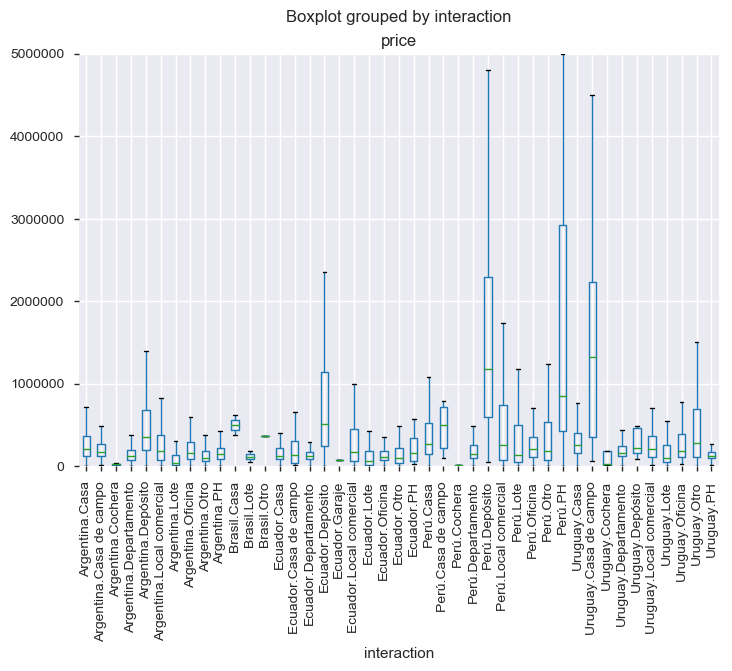

In [162]:
# Plot price distributions by country*property_type
plt.figure(figsize = (30, 20), facecolor = 'w', edgecolor = 'r')

plt.sca(final_df3.boxplot(column = 'price', by = 'interaction'))
plt.ylim(0, 5000000)
plt.xticks(rotation = 90)
plt.savefig('interaction.png', dpi = 120, bbox_inches = 'tight')

(0, 800000)

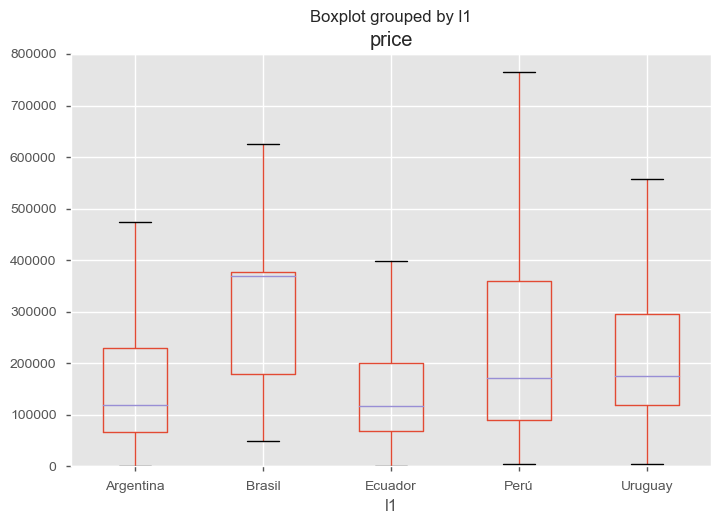

In [165]:
# Boxplots of price by country
plt.sca(final_df3.boxplot(column = 'price', by = 'l1'))
plt.ylim(0, 800000)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Text xticklabel objects>)

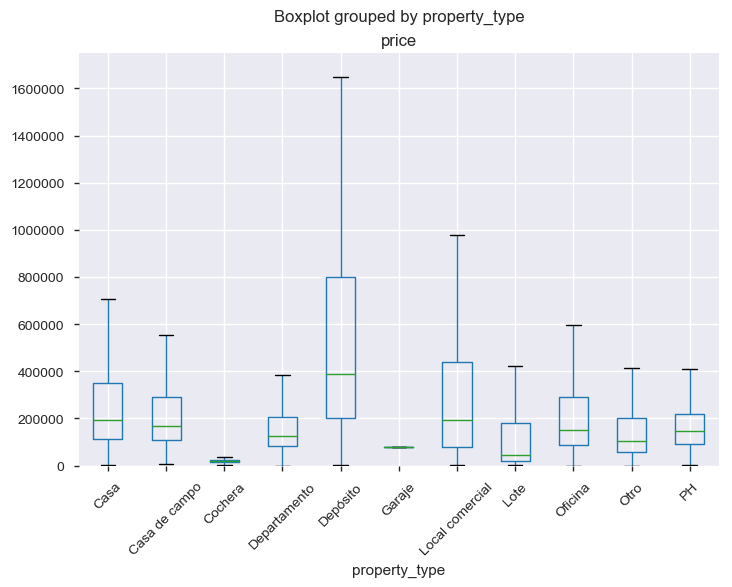

In [158]:
# Boxplots of price by property_type
plt.sca(final_df3.boxplot(column = 'price', by = 'property_type'))
plt.ylim(0, 1750000)
plt.xticks(rotation = 45)

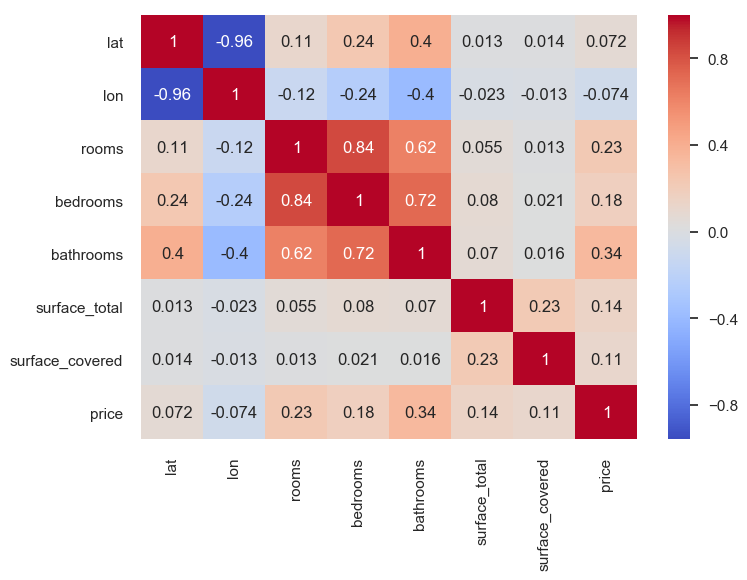

In [174]:
# Correlation heatmap
sns.set(style = 'darkgrid')
sns.heatmap(final_df3.corr(), cmap = 'coolwarm', annot = True)

C:\Users\Tpeng\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Tpeng\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Tpeng\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Tpeng\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * 

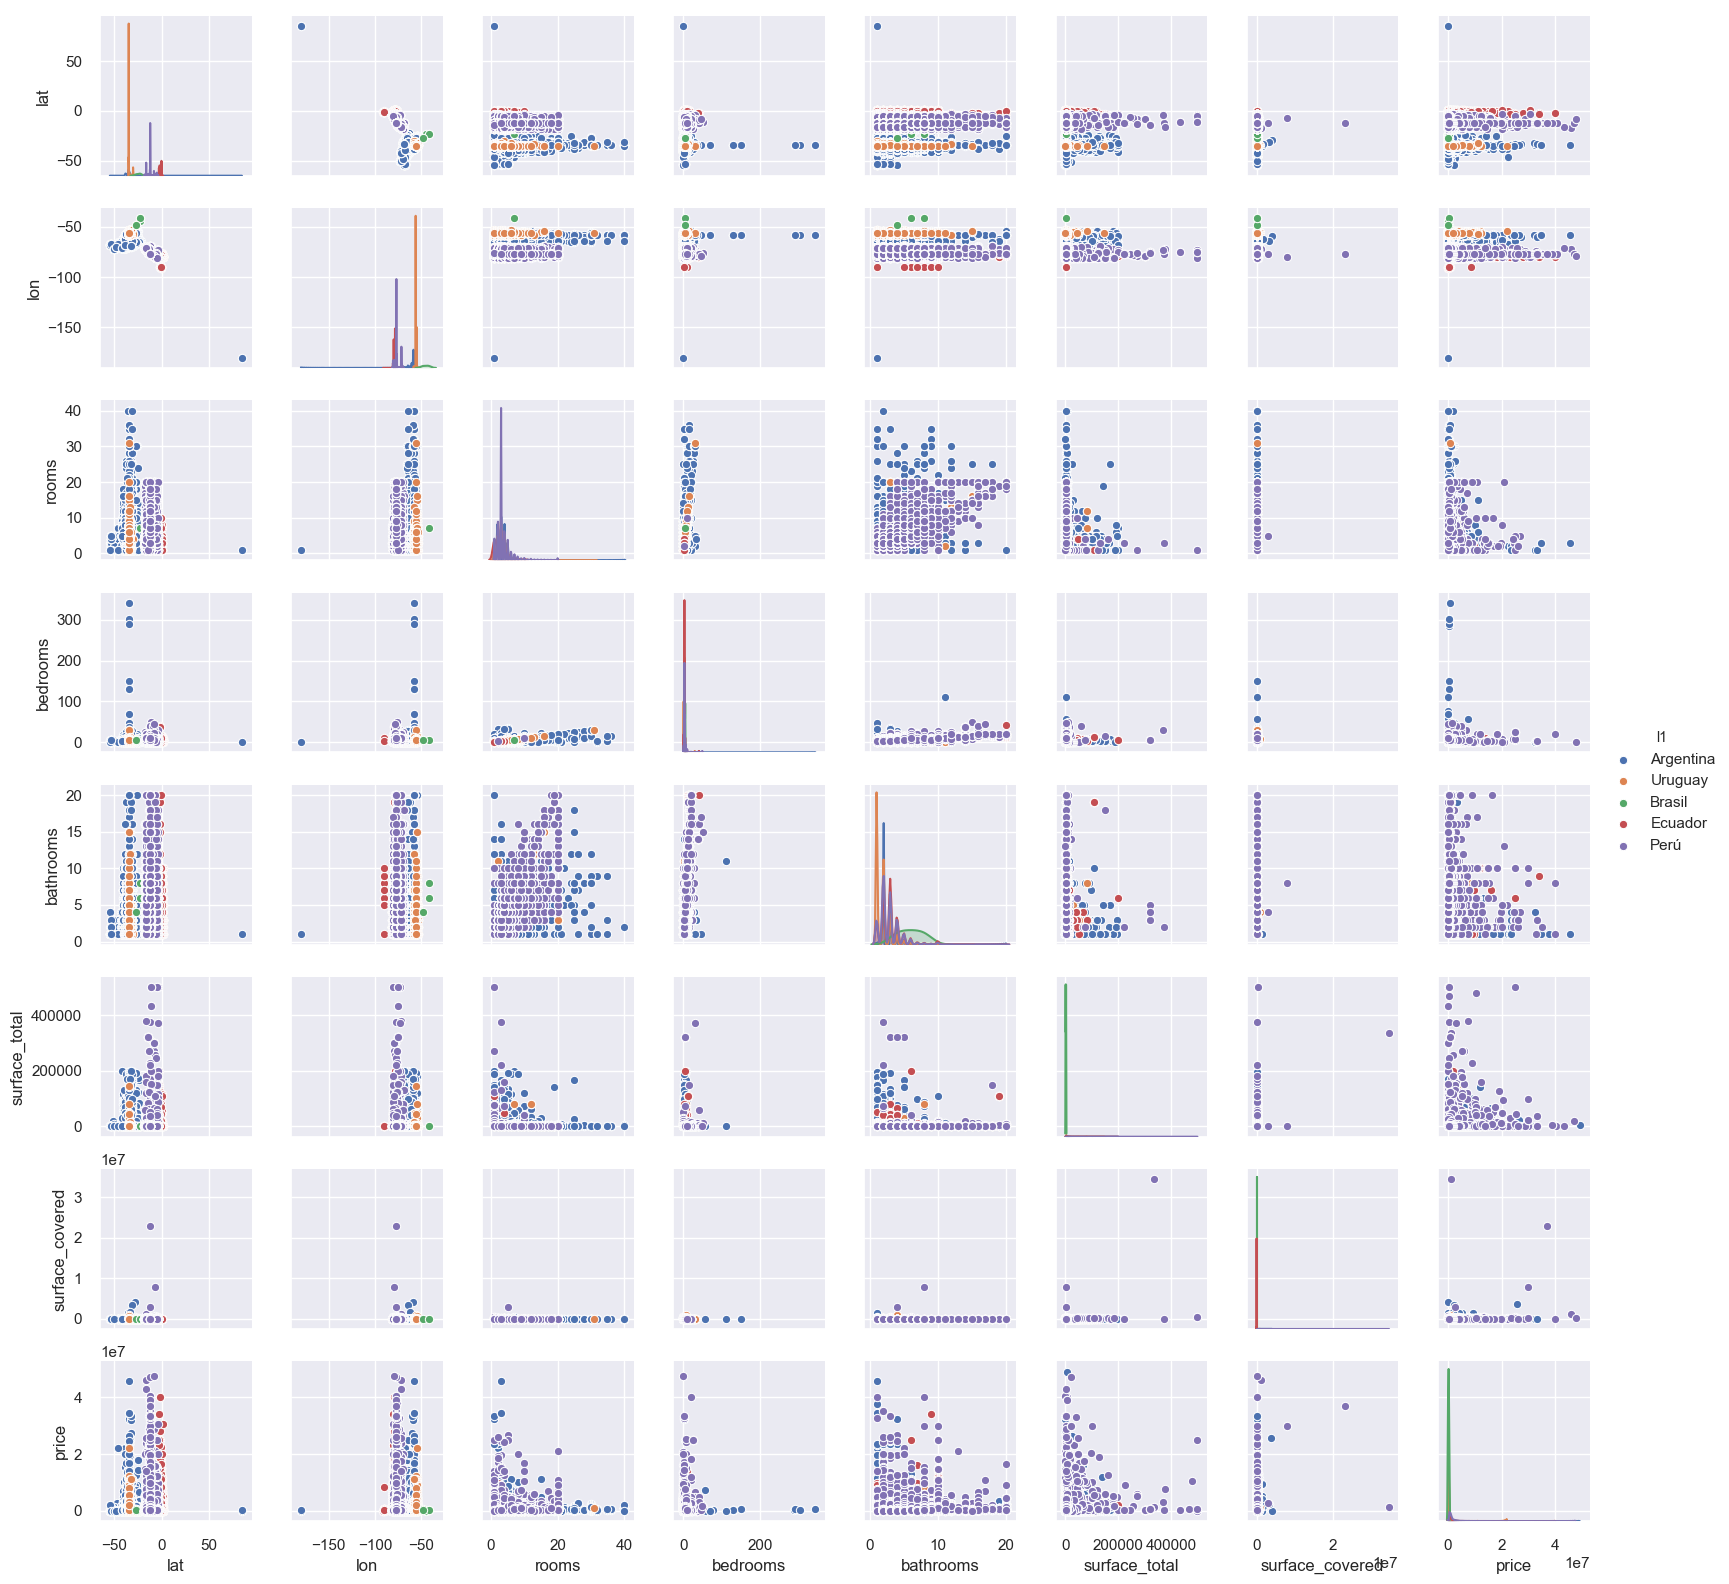

In [176]:
sns.pairplot(final_df3, hue= 'l1', size = 2)

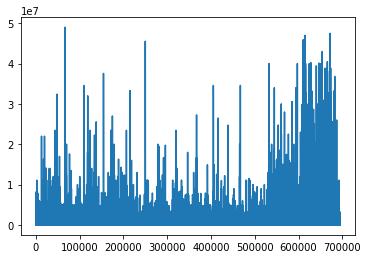

In [55]:
# Explore price # Don't use
axes=final_df3.loc[:, 'price']
axes.plot()
#final_df3.loc[:, ]

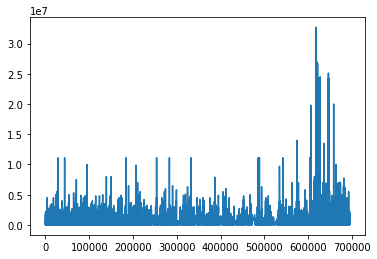

In [48]:
axes=final_df3.loc[final_df3.property_type == 'Casa', 'price']
axes.plot()

In [30]:
# Get variance of attributes by property type
#final_df3.agg(func = 'var', axis = 0).groupby(by = 'property_type')
#print(final_df3.groupby(by = 'property_type').var)

<bound method GroupBy.var of <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x000001DE66366D68>>


In [6]:
# 3. Visualize the most important attributes appropriately (AT LEAST 5 ATTRIBUTES)
# Provide an interpretation for each chart
# Explain each attribute why the chosen visualization is appropriate


In [7]:
# 4. Explain relationships b/t attributes
# Scatterplots, correlations, cross-tabulation, group-wise averages, etc. as appropriate and explain interesting relationships.


In [8]:
# 5. Identify and explain interesting relationships b/t features and the class you are trying to predict (ie. rel b/t
# vars and the target classification)


In [9]:
# 6. Are there other features that could be added to the data or created from existing features? Which ones?


In [ ]:
########## Exceptional Work ##########

# Free reign to provide additional analyses
# Idea: implement dimensionality reduction, then visualize and interpret the results

# Other Ideas:

In [179]:
# Try PCA, though it is not recommended for categorical variables
Y = final_df3['price']
X = final_df3.drop(labels = 'price', axis = 1)